In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from wordfreq import top_n_list, word_frequency

%matplotlib inline

In [2]:
JSON_DIR = Path("data/json/")

# https://half-life.fandom.com/wiki/Gordon_Freeman
with open(JSON_DIR / "wiki_long.json", "r", encoding="utf-8") as file:
    wiki_long = json.load(file)

# https://half-life.fandom.com/wiki/Protozoan
with open(JSON_DIR / "wiki_low.json", "r", encoding="utf-8") as file:
    wiki_low = json.load(file)

# https://en.wikipedia.org/wiki/Earth
with open(JSON_DIR / "sample_en.json", "r", encoding="utf-8") as file:
    sample_en = json.load(file)

# https://nl.wikipedia.org/wiki/Aarde_(planeet)
with open(JSON_DIR / "sample_nl.json", "r", encoding="utf-8") as file:
    sample_nl = json.load(file)

# https://pl.wikipedia.org/wiki/Ziemia
with open(JSON_DIR / "sample_pl.json", "r", encoding="utf-8") as file:
    sample_pl = json.load(file)

all_word_counts = [wiki_long, wiki_low, sample_en, sample_nl, sample_pl]

### Hellinger distance and `lang_confidence_score()`

---

In probability and statistics, the Hellinger distance is used to quantify the similarity between two probability distributions.

For two discrete probability distributions $P = (p_1, \dots, p_k)$ and $Q = (q_1, \dots, q_k)$, their Hellinger distance is defined as
$$H(P, Q) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^k (\sqrt{p_i} - \sqrt{q_i})^2}$$

The maximum distance 1 is achieved when $P$ assigns probability zero to every set to which $Q$ assigns a positive probability, and vice versa.

<small> Source: https://en.wikipedia.org/wiki/Hellinger_distance </small>

In [3]:
def hellinger_distance(p, q) -> float:
    norm = np.linalg.norm(np.sqrt(p) - np.sqrt(q))
    return norm / np.sqrt(2)


def lang_confidence_score(word_counts, language_words_with_frequency) -> float:
    # Filter out empty or missing data.
    if (not word_counts) or (not language_words_with_frequency):
        return 0.0

    word_values = list(word_counts.values())
    lang_values = list(language_words_with_frequency.values())

    # Filter out invalid data (min) and prevent further division by zero (sum).
    if (
        min(
            np.min(word_values),
            np.min(lang_values),
            np.sum(word_values),
            np.sum(lang_values),
        )
        <= 0.0
    ):
        return 0.0

    # Combine the keys from both dictionaries.
    keys = set(word_counts) | set(language_words_with_frequency)

    total = np.sum(word_values)

    # Now that the keys are equal, we only need values.
    # Note: word counts get converted to word frequencies.
    word_freq = [word_counts.get(key, 0.0) / total for key in keys]
    lang_freq = [language_words_with_frequency.get(key, 0.0) for key in keys]

    word_freq, lang_freq = np.array(word_freq), np.array(lang_freq)

    # Hellinger distance requires probability distributions.
    # Softmax is not suitable here because of possible outliers.
    word_freq /= word_freq.sum()
    lang_freq /= lang_freq.sum()

    return 1.0 - hellinger_distance(word_freq, lang_freq)


### Visualization

In [4]:
def get_data(k: int):
    entry = []

    for lang in ["en", "nl", "pl"]:
        lang_frequencies = {
            word: word_frequency(word, lang) for word in top_n_list(lang, k)
        }

        for word_counts in all_word_counts:
            entry.append(lang_confidence_score(word_counts, lang_frequencies))

    return np.array(entry).reshape((3, 5))


data = {k: get_data(k) for k in [3, 10, 100, 1000]}

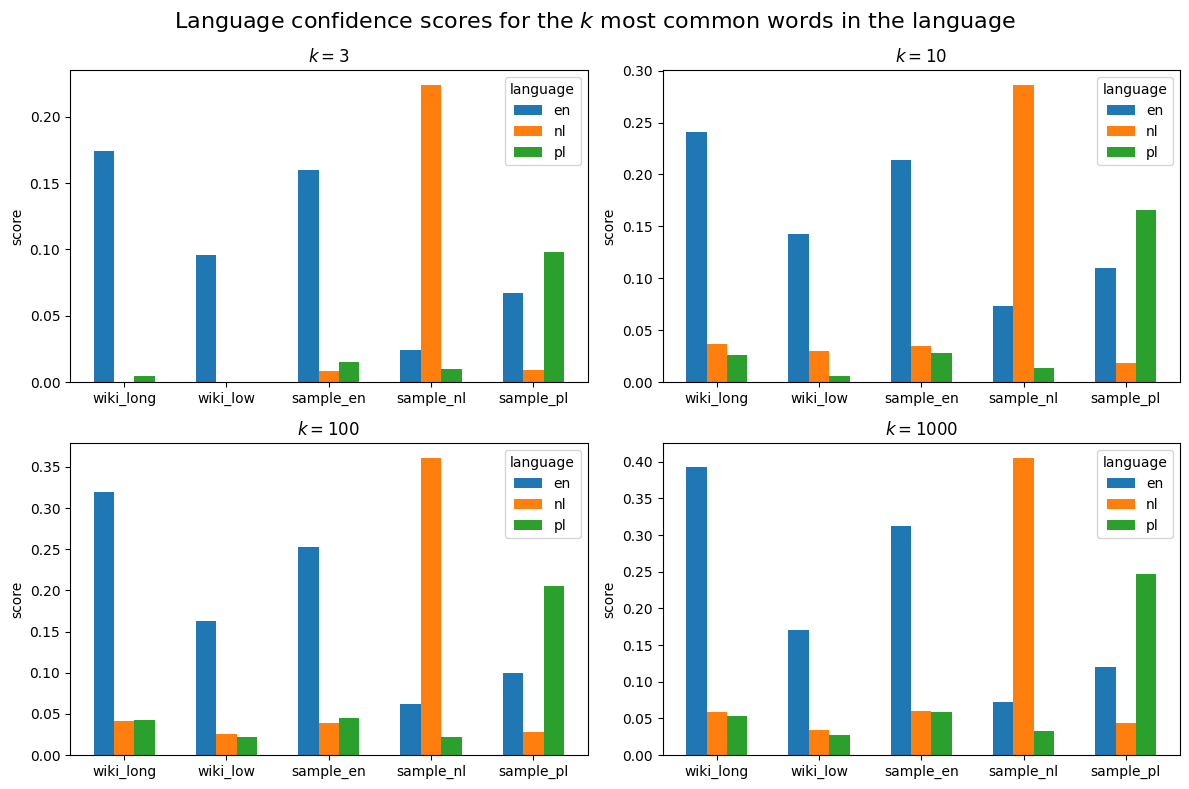

In [5]:
# Labels for the X-axis.
xlabels = ["wiki_long", "wiki_low", "sample_en", "sample_nl", "sample_pl"]

# Bar width and x locations.
w, x = 0.2, np.arange(len(xlabels))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

fig.suptitle(
    "Language confidence scores for the $k$ most common words in the language",
    fontsize=16,
)

# Configure each (k = 3, 10, 100, 1000) chart separately.
for k, ax in zip([3, 10, 100, 1000], axes.flatten()):
    ax.bar(x - w, data[k][0], w, label="en")
    ax.bar(x, data[k][1], w, label="nl")
    ax.bar(x + w, data[k][2], w, label="pl")

    ax.set_title(f"$k = {k}$")
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel("score")
    ax.legend(title="language")

plt.tight_layout()
plt.show()

Metoda jest skuteczna, ponieważ w każdym przypadku poprawnie identyfikuje język danego tekstu.

Zauważalna jest zarówno przewaga języka w odpowiadającej mu próbce, jak również - dla artykułów z wiki - przewaga języka angielskiego nad pozostałymi.

Maksymalne wartości `score` są niewielkie i rosną wraz ze wzrostem parametru $k$, co najprawdopodobniej spowodowane jest łączeniem kluczy w `lang_confidence_score()`. Nie wpływa to jednak na skuteczność metody.

---

#### Czy dobór języków miał duże znaczenie?

Nie, bo każdy z nich wyraźnie dominuje tam, gdzie powinien.

Język niderlandzki jest [jednym z bardziej zbliżonych do angielskiego](https://www.babbel.com/en/magazine/languages-closest-to-english), co można zaobserwować szczególnie przy $k = 10$. W pozostałych przypadkach podobieństwo to jest jednak niewystarczające, by miało ono jakkolwiek istotne znaczenie.

---

#### Czy po wartościach `language_words_with_frequency` dla danych i najczęstszych słowach z języka danych widać, że w wybranym języku słowa często są odmieniane?

Tak, w języku polskim.

Niezależnie od wartości $k$, spośród wszystkich tekstów:
- `sample_en`
- `sample_nl`
- `sample_pl`

to właśnie ten język wykazuje najmniejsze dopasowanie do samego siebie.

---

#### Czy trudne było znalezienie takiego artykułu, dla którego wynik `language_words_with_frequency` jest jak najmniejszy w języku wiki? Czy to specyfika tego wiki?

Nie.

Jest to specyfika tego wiki, ponieważ jest w nim (względnie) dużo fikcyjnych nazw własnych, które nie występują w języku.

Artykuł wykorzystany w `wiki_low` jest ponadto dość krótki i zawiera kilka słów z języka greckiego.